$\color{red}{\text{Pour exécution dans Google Colab}}$
*(1.5 minutes)* :

*   Menu Affichage -> ***Réduire les rubriques*** ;

*   Se positionner sur la ligne en rouge **"Attention : ne pas exécuter le code en dessous de cette ligne"** (voir sommaire à gauche);

*   Menu Exécution -> ***Exécuter avant*** (pour éviter de lancer les cellules plus bas, aux temps de traitement très longs).

# INTRODUCTION

Ce fichier est le notebook du modèle de régression retenu (PassiveAgressiveRegressor) pour la prédiction des temps de réponses en secondes (AttendanceTimeSeconds) des véhicules, sur une intervention.

---
Pour information, le détail des travaux (amenant à ce modèle / en support au rapport) est dans le notebook : *3.3 Prédiction temps arrivée Workbook.ipynb*

---



Ce notebook est divisé en 4 grandes parties.

1. **Les travaux préliminaires**

Paramétrages, importations des modules utiles pour la suite, lecture du fichier de base, préparation des données pour les intégrer dans des modèles de Machine Learning, et paramétrages généraux (listes, fonctions) de ces modèles.

2. **Le modèle de Machine Learning**

Pour le modèle retenu (sauvegardé pour éviter de devoir l'entraîner de nouveau), génération des prédictions, calcul des métriques étudiées, visualisation de l'importance des variables, et graphiques de comparaison réel / prédictions.

3. **Les diagnostics du modèles**

Proposition d'une approche pour combler les lacunes du modèle, puis rapprochement avec le modèle de classification réalisé à l'étape précédente (0/1 si le véhicule arrive dans un délai de 360 secondes, ou plus).

4. **Application à quelques incidents**

Quelques incidents sélectionnés, avec le retour des prédictions et alertes du modèle.


5. **La construction de l'algorithme de Machine Learning**

Cette dernière partie est en réalité la phase de construction des modèles sauvegardés, venant juste après les travaux prélimiaires. Elle est placée en fin de notebook, pour permettre de ne pas l'exécuter de nouveau : recherches des paramètres optimaux par gridsearchcv, entrainement et sauvegarde (sauvegarde volontairement "commentée" pour ne pas écraser par mégarde celui déjà sauvegardé).

# TRAVAUX PRELIMINAIRES


In [ ]:
# Monter google drive dans Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Paramètres dossiers et fichiers

In [ ]:
#################### POUR EXECUTION SUR GOOGLE DRIVE ####################

# Fichier de base
database = '/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/base_ml.pkl'

# Dossier où les modèles de ML entraînés sont enregistrés
reg_saved = '/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_attendance_time/'


## Modules

In [ ]:
# installation sur Colab des modules complémentaires
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 4.6 MB/s 


In [ ]:
# Importation des modules nécessaires

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm

# Option à modifier pour visualiser la totalité des colonnes
pd.set_option('display.max_columns', None)

# pour machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.linear_model import PassiveAggressiveRegressor
from joblib import dump, load
import shap

# pour rapprochement des résultats avec classification +/- 360 secondes
from sklearn.metrics import classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Lecture du fichier

In [ ]:
# Charger le dataframe nettoyé et complété
df = pd.read_pickle(database)

# garder une copie de la base complète (utile pour l'analyse plus tard)
df_full = df.copy()

In [ ]:
# Aperçu du fichier
df.head()

,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
0,000412-01012018,F261,2018-01-01,74,191,265,F26,Bethnal Green,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Park,Open land/water - nearest gazetteer location,Bethnal Green,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.629,2,1,F26,F26,0,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
1,000413-01012018,G272,2018-01-01,85,109,194,G27,North Kensington,Home Station,1,No delay,Pump Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,North Kensington,1,1,1,Domestic Incidents,Effecting entry/exit,0,0.849,3,2,G27,G27,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
2,000415-01012018,G301,2018-01-01,72,167,239,G30,Wembley,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Tree scrub,On land associated with building,Wembley,1,1,1,Fire,Secondary Fire,0,1.319,4,2,G30,G30,0,2,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
3,000417-01012018,G291,2018-01-01,123,364,487,G29,Park Royal,Home Station,1,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,1.296,3,2,G29,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47
4,000417-01012018,G281,2018-01-01,40,453,493,G28,Willesden,Home Station,2,Address incomplete/wrong,Pump Dual Ladder,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,Wembley,2,2,1,Fire,False alarm - Good intent,1,2.728,4,2,G28,G30,1,1,2018,1,1,Monday,18,7.0,0.3,0.2,29.0,Rain,rain,0,1.0,0.47


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547865 entries, 0 to 547864
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   IncidentNumber                 547865 non-null  object        
 1   Resource_Code                  547865 non-null  object        
 2   DateAndTimeMobilised           547865 non-null  datetime64[ns]
 3   TurnoutTimeSeconds             547865 non-null  int64         
 4   TravelTimeSeconds              547865 non-null  int64         
 5   AttendanceTimeSeconds          547865 non-null  int64         
 6   DeployedFromStation_Code       547865 non-null  object        
 7   DeployedFromStation_Name       547865 non-null  object        
 8   DeployedFromLocation           547865 non-null  object        
 9   PumpOrder                      547865 non-null  int64         
 10  DelayCode_Description          547865 non-null  object        
 11  

In [ ]:
df.isna().sum()[df.isna().sum() != 0]

Series([], dtype: int64)

## Préparation pour ventilation train / test

In [ ]:
# Jeux de données entrainement et test : travaux préliminaire pour choix des numéros d'incidents

# paramètres généraux
tts_test_size = 0.2    # définir la proportion du nombre d'incidents à affecter au jeu de test
np.random.seed(42)     # fixer le caractère aléatoire (même base + même seed => donnera même liste dans les 3 modèles)

# Faire la liste des incidents et la trier
tts_inc_list = df['IncidentNumber'].unique().tolist()
tts_inc_list.sort()

# Total des véhicules et incidents pour juger de la répartition train / test
tts_nb_pump = df.shape[0]
tts_nb_inc = len(tts_inc_list)

# Taille de la liste des incidents à mettre en jeu de test
tts_test_size_nb = np.int64(tts_nb_inc * tts_test_size)

# liste des n° d'incidents à garder dans le jeu de test = sélectionner 'test_size_nb' éléments de la liste, par un tirage sans remise
tts_inc_test_list = list(np.random.choice(tts_inc_list, tts_test_size_nb, replace= False))

# sauvegarder les index des lignes des incidents que l'on affectera en test et train
# car nous allons ensuite supprimer la variable 'IncidentNumber'
tts_index_test = df[df['IncidentNumber'].isin(tts_inc_test_list)].index
tts_index_train = df[~df['IncidentNumber'].isin(tts_inc_test_list)].index

## Nettoyage

In [ ]:
# Rappel de la base
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547865 entries, 0 to 547864
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   IncidentNumber                 547865 non-null  object        
 1   Resource_Code                  547865 non-null  object        
 2   DateAndTimeMobilised           547865 non-null  datetime64[ns]
 3   TurnoutTimeSeconds             547865 non-null  int64         
 4   TravelTimeSeconds              547865 non-null  int64         
 5   AttendanceTimeSeconds          547865 non-null  int64         
 6   DeployedFromStation_Code       547865 non-null  object        
 7   DeployedFromStation_Name       547865 non-null  object        
 8   DeployedFromLocation           547865 non-null  object        
 9   PumpOrder                      547865 non-null  int64         
 10  DelayCode_Description          547865 non-null  object        
 11  

In [ ]:
# Caserne de base VS caserne de provenance ; que garder ?

# répartition des observations selon le lieu de leur départ (au moment de la mobilisation) :
df.groupby('DeployedFromLocation').count()['IncidentNumber']

DeployedFromLocation
Home Station     529734
Other Station     18131
Name: IncidentNumber, dtype: int64

On constate que la quasi totalité des véhicules partent de leur caserne de base.

Rares sont les cas où les véhicules proviennent d'une autre caserne que la leur.

On a 2 options possibles :
1.   on garde un maximum de détail : la caserne de base du véhicule + la caserne de départ du véhicule au moment de la mobilisation (sachant que ce sont des variables comptant chacune 102 modalités, qu'il nous faudra dichotomiser pour exploiter) ;
2.   on ne conserve que la caserne de base du véhicule, avec une indication permettant de savoir s'il était à sa caserne au moment de la mobilisation, ou dans une autre caserne.


Compte tenu du faible poids des "Other Station", on comprend que dans la quasi totalité des interventions, le véhicule est parti de sa caserne de base.

Aussi, notre choix se portera sur la seconde option, ce qui sera également utile pour limiter la taille de notre base après dichotomisation.

Nous ne conserverons donc que :
*   **Station_Code_of_ressource** = le code de la caserne où est basé le véhicule ;
*   **DeployedFromLocation** = la variable permettant de savoir si ce véhicule est en provenance de sa propre caserne, ou d'une autre, au moment où il est mobilisé (au lieu de la variable DeployedFromStation_Code).


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


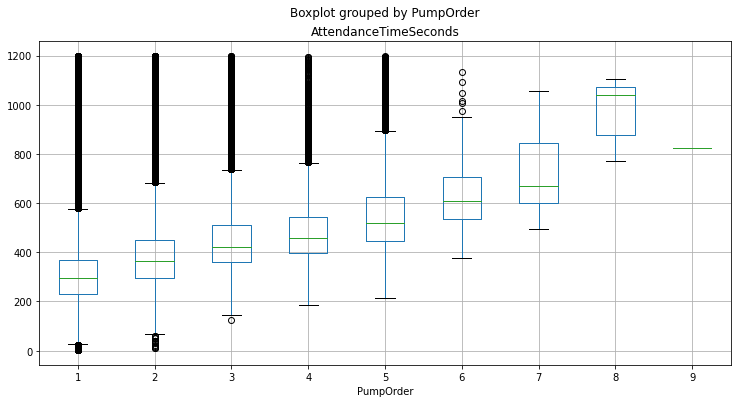

In [ ]:
# Visu de la distribution des temps de réponse, en fonction de l'ordre d'arrivée des véhicules
df.boxplot(column='AttendanceTimeSeconds', by='PumpOrder', figsize=(12,6));

PumpOrder
1    358321
2    139974
3     26205
4     13172
5     10061
6       112
7        13
8         6
9         1
Name: AttendanceTimeSeconds, dtype: int64


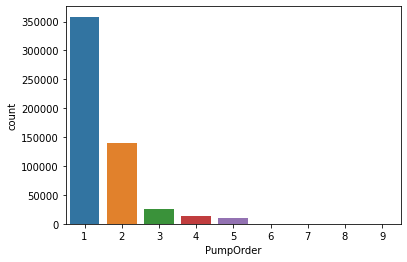

In [ ]:
# Visu des nombres de camions par position d'arrivée
print(df.groupby(by='PumpOrder')['AttendanceTimeSeconds'].count())
sns.countplot(x = df['PumpOrder'])

In [ ]:
# suppression toutes les variables datetime
df = df.drop(df.select_dtypes("datetime").columns, axis = 1)

In [ ]:
# Suppression des variables inutiles
# les variables à supprimer sont commentées; celles à garder sont décommentées

df = df[[
         #'IncidentNumber',                   # SUPPR # aucune utilité
         #'Resource_Code',                    # SUPPR # correspond à Station_Code_of_ressource + Appliance
         #'DateAndTimeMobilised',             # SUPPR # déjà supprimé plus haut
         #'TurnoutTimeSeconds',               # SUPPR # pas utile
         #'TravelTimeSeconds',                # SUPPR # pas utile
         'AttendanceTimeSeconds',                     # Target !
         #'DeployedFromStation_Code',         # SUPPR # correspond à Station_Code_of_ressource
         #'DeployedFromStation_Name',         # SUPPR # correspond à Station_Code_of_ressourc
         'DeployedFromLocation',                      # Home station ou Other station
         #'PumpOrder',                        # SUPPR # info à posteriori 
         #'DelayCode_Description',            # SUPPR # 
         'Appliance',                                 # type de véhicule
         'PropertyCategory',                          # conservé pour l'instant, voir impact utilisation vs 9 colonnes
         #'PropertyType',                     # SUPPR # objet des 9 colonnes property
         'AddressQualifier',                          # à conserver
         #'IncidentStationGround',            # SUPPR # utilisation de IncidentStationGround_Code repris plus loin
         #'NumStationsWithPumpsAttending',    # SUPPR # info à posteriori
         #'NumPumpsAttending',                # SUPPR # info à posteriori / sera l'objet des prédictions Christophe
         #'TimeOnIncidentSeconds',            # SUPPR # info à posteriori
         #'TimeTotalSeconds',                 # SUPPR # info à posteriori
         #'Mobilised_Rank',                   # SUPPR # cara base déjà filtrée sur valeur = 1
         #'Outdoor Structure',                # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Road Vehicle',                     # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Outdoor',                          # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Dwelling',                         # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Other Residential',                # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Aircraft',                         # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Boat',                             # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Rail Vehicle',                     # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         #'Non Residential',                  # SUPPR # groupe 9 colonnes travaux property -> suppr suite revue 24/02/22
         'IncidentType',                              # 6 modalités à dichotomiser
         #'IncidentCategory',                 # SUPPR # niveau de détail de IncidenType trop nombreuses modalités + à posteriori
         #'FalseAlarm',                       # SUPPR # info à posteriori
         'Distance',                                  # paramètre distance = important
         'TotalOfPumpInLondon_Out',                   # paramètre "d'engorgement" des casernes au moment de l'appel
         #'PumpByStation',                    # SUPPR # nombre de camions dans la caserne => on a déjà le nb dispo, suffisant
         'Station_Code_of_ressource',                 # code station du véhicule qui est envoyé sur cet appel
         'IncidentStationGround_Code',                # code station dont dépend le lieu de l'incident (station responsable du secteur)
         #'PumpOfIncidentStation_Out',        # SUPPR # on a déjà le nombre de camions dispo
         'PumpAvailable',                             # nombre de camions dispo (pas en intervention) dans la StationGround -> correction suite revue 24/02/22 (supprimé par erreur)
         #'year',                             # SUPPR # pas besoin de cette info
         'month',                                     # à garder
         #'day',                              # SUPPR # jour dans le mois -> gardé suite revue 24/02/22 -> suppr suite discusson 14/03/22
         #'weekday',                          # SUPPR # car maintenant intégré dans congestion rate
         #'hour',                             # SUPPR # car maintenant intégré dans congestion rate
         'temp',                                      # à garder
         'precip',                                    # à garder
         'cloudcover',                                # à garder
         'visibility',                                # à garder
         'conditions',                                # à garder  
         #'icon',                             # SUPPR # doublon avec conditions        
         #'blank',                            # SUPPR # à été supprimé le 14/03/22, remplacé par 2 autres colonnes
         'workingday',                                # à garder
         'school_holidays',                           # à garder
         'congestion_rate',                           # taux congestion traffic
         ]]


## Dataviz et préparation Machine Learning

### Visu des données

In [ ]:
# résumé du dataframe nettoyé pour les algo de ML
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547865 entries, 0 to 547864
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable               547865 non-null  int64  
 11  month                       547865 non-null  int64  
 12  temp                        547865 non-null  float64
 13  precip        

In [ ]:
df.head()

,AttendanceTimeSeconds,DeployedFromLocation,Appliance,PropertyCategory,AddressQualifier,IncidentType,Distance,TotalOfPumpInLondon_Out,Station_Code_of_ressource,IncidentStationGround_Code,PumpAvailable,month,temp,precip,cloudcover,visibility,conditions,workingday,school_holidays,congestion_rate
0,265,Home Station,Pump Dual Ladder,Outdoor,Open land/water - nearest gazetteer location,Domestic Incidents,0.629,2,F26,F26,1,1,7.0,0.3,0.2,29.0,Rain,0,1.0,0.47
1,194,Home Station,Pump Ladder,Dwelling,Correct incident location,Domestic Incidents,0.849,3,G27,G27,2,1,7.0,0.3,0.2,29.0,Rain,0,1.0,0.47
2,239,Home Station,Pump Dual Ladder,Outdoor,On land associated with building,Fire,1.319,4,G30,G30,2,1,7.0,0.3,0.2,29.0,Rain,0,1.0,0.47
3,487,Home Station,Pump Dual Ladder,Outdoor,On land associated with building,Fire,1.296,3,G29,G30,1,1,7.0,0.3,0.2,29.0,Rain,0,1.0,0.47
4,493,Home Station,Pump Dual Ladder,Outdoor,On land associated with building,Fire,2.728,4,G28,G30,1,1,7.0,0.3,0.2,29.0,Rain,0,1.0,0.47


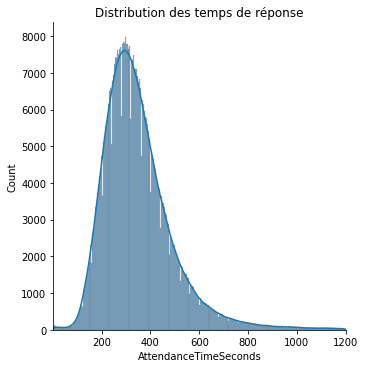

In [ ]:
# Distribution des temps de réponse
sns.displot(df['AttendanceTimeSeconds'], kde=True)
plt.title('Distribution des temps de réponse')
plt.xlim([df['AttendanceTimeSeconds'].min(), df['AttendanceTimeSeconds'].max()]);


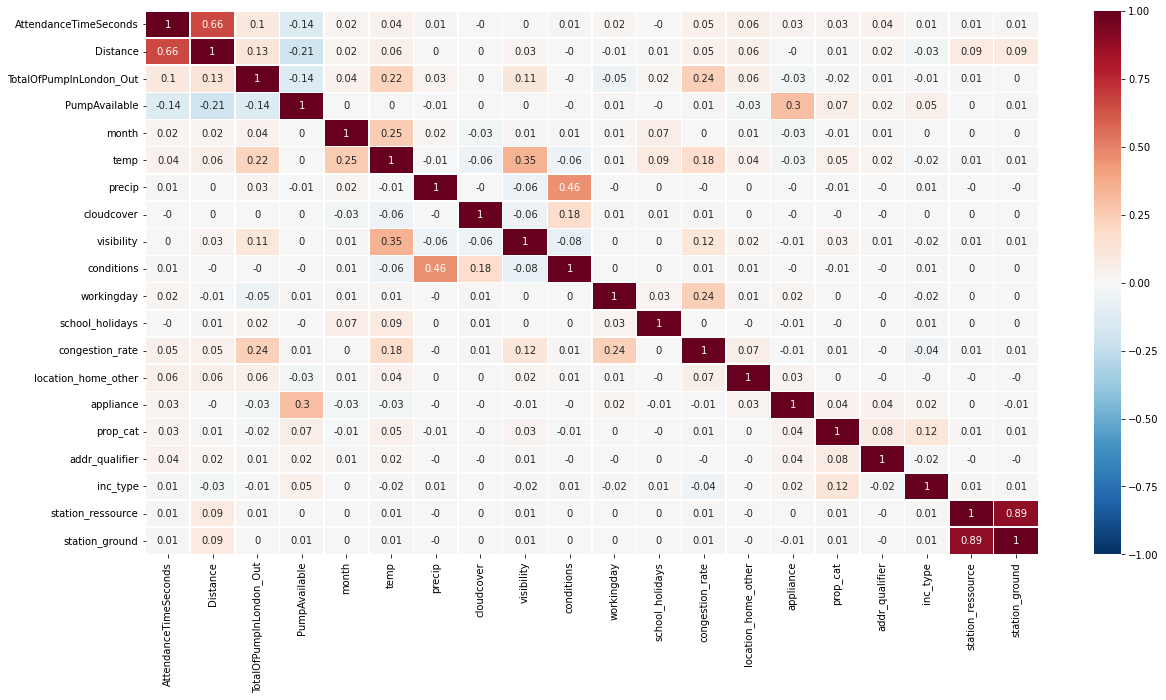

In [ ]:
# Visu des corrélations entre variables

plt.figure(figsize=(20,10))
sns.heatmap(np.round(df.assign(location_home_other = df.DeployedFromLocation.astype('category').cat.codes,
                                appliance = df.Appliance.astype('category').cat.codes,
                                prop_cat = df.PropertyCategory.astype('category').cat.codes,
                                addr_qualifier = df.AddressQualifier.astype('category').cat.codes,
                                inc_type = df.IncidentType.astype('category').cat.codes,
                                station_ressource = df.Station_Code_of_ressource.astype('category').cat.codes,
                                conditions = df.conditions.astype('category').cat.codes,
                                workingday = df.workingday.astype('category').cat.codes,
                                school_holidays = df.school_holidays.astype('category').cat.codes,
                                station_ground = df.IncidentStationGround_Code.astype('category').cat.codes).corr(), 2),
            center = 0, cmap='RdBu_r', annot=True, vmin=-1, vmax=1, linewidths=0.5);

# AttendanceTimeSeconds est notre variable à prédire (temps de réponse)
# on remarque que la distance est LA variable explicative principale
# puis sur un second plan, vient la variable PumpAvailable, indiquant la disponibilité du matériel.

# Cette configuration reflète bien l'efficacité de la LFB, démontrant ainsi que la priorité est l'intervention rapide.

### Préparation des données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547865 entries, 0 to 547864
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable               547865 non-null  int64  
 11  month                       547865 non-null  int64  
 12  temp                        547865 non-null  float64
 13  precip        

In [ ]:
def reg_var_type(df):
    '''
    Corriger les types pour 4 variables d'un df,
    et les rendre exploitable comme souhaité pour le ML.
    Variables concernées :
        PumpAvailable, month, workingday, school_holidays
    '''
    # convertir 'PumpAvailable' (considérée catégorielle / paliers / peu de modalités) au format string (en vue de dichotomisation)
    df['PumpAvailable'] = df['PumpAvailable'].astype(str)
    print("'PumpAvailable' a été converti en 'object'")

    # convertir 'month' au format integer
    df['month'] = df['month'].astype('uint8')
    print("'month' a été converti en 'uint8'")

    # convertir 'workingday' et 'school_holidays' au format integer (variables binaires 0/1, pour ne pas dichotomiser)
    df['workingday'] = df['workingday'].astype('uint8')
    print("'workingday' a été converti en 'uint8'")
    df['school_holidays'] = df['school_holidays'].astype('uint8')
    print("'school_holidays' a été converti en 'uint8'\n")

    return df.info()

reg_var_type(df)

'PumpAvailable' a été converti en 'object'
'month' a été converti en 'uint8'
'workingday' a été converti en 'uint8'
'school_holidays' a été converti en 'uint8'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547865 entries, 0 to 547864
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AttendanceTimeSeconds       547865 non-null  int64  
 1   DeployedFromLocation        547865 non-null  object 
 2   Appliance                   547865 non-null  object 
 3   PropertyCategory            547865 non-null  object 
 4   AddressQualifier            547865 non-null  object 
 5   IncidentType                547865 non-null  object 
 6   Distance                    547865 non-null  float64
 7   TotalOfPumpInLondon_Out     547865 non-null  int64  
 8   Station_Code_of_ressource   547865 non-null  object 
 9   IncidentStationGround_Code  547865 non-null  object 
 10  PumpAvailable              

In [ ]:
# séparer target / features
target = df['AttendanceTimeSeconds']
data = df.drop('AttendanceTimeSeconds', axis = 1)

# dichotomisation de toutes les variables 'object'
data = pd.get_dummies(data)

data.shape

(547865, 254)

In [ ]:
data.head()

,Distance,TotalOfPumpInLondon_Out,month,temp,precip,cloudcover,visibility,workingday,school_holidays,congestion_rate,DeployedFromLocation_Home Station,DeployedFromLocation_Other Station,Appliance_Pump Dual Ladder,Appliance_Pump Ladder,PropertyCategory_Aircraft,PropertyCategory_Boat,PropertyCategory_Dwelling,PropertyCategory_Non Residential,PropertyCategory_Other Residential,PropertyCategory_Outdoor,PropertyCategory_Outdoor Structure,PropertyCategory_Rail Vehicle,PropertyCategory_Road Vehicle,AddressQualifier_Correct incident location,AddressQualifier_In street close to gazetteer location,AddressQualifier_In street outside gazetteer location,AddressQualifier_In street remote from gazetteer location,AddressQualifier_Nearby address - no building in street,AddressQualifier_Nearby address - street not listed in gazetteer,AddressQualifier_On land associated with building,AddressQualifier_On motorway / elevated road,AddressQualifier_Open land/water - nearest gazetteer location,AddressQualifier_Railway land or rolling stock,AddressQualifier_Within same building,IncidentType_Domestic Incidents,IncidentType_Fire,IncidentType_Local Emergencies,IncidentType_Major Environmental Disasters,IncidentType_Prior Arrangement,IncidentType_Use of Special Operations Room,Station_Code_of_ressource_A21,Station_Code_of_ressource_A23,Station_Code_of_ressource_A24,Station_Code_of_ressource_A28,Station_Code_of_ressource_A30,Station_Code_of_ressource_A31,Station_Code_of_ressource_A32,Station_Code_of_ressource_A33,Station_Code_of_ressource_A34,Station_Code_of_ressource_A35,Station_Code_of_ressource_A36,Station_Code_of_ressource_A37,Station_Code_of_ressource_A38,Station_Code_of_ressource_A39,Station_Code_of_ressource_A40,Station_Code_of_ressource_A41,Station_Code_of_ressource_A43,Station_Code_of_ressource_E21,Station_Code_of_ressource_E22,Station_Code_of_ressource_E23,Station_Code_of_ressource_E25,Station_Code_of_ressource_E27,Station_Code_of_ressource_E28,Station_Code_of_ressource_E29,Station_Code_of_ressource_E30,Station_Code_of_ressource_E31,Station_Code_of_ressource_E34,Station_Code_of_ressource_E35,Station_Code_of_ressource_E36,Station_Code_of_ressource_E37,Station_Code_of_ressource_E38,Station_Code_of_ressource_E39,Station_Code_of_ressource_E40,Station_Code_of_ressource_E41,Station_Code_of_ressource_E42,Station_Code_of_ressource_E43,Station_Code_of_ressource_F21,Station_Code_of_ressource_F22,Station_Code_of_ressource_F23,Station_Code_of_ressource_F24,Station_Code_of_ressource_F25,Station_Code_of_ressource_F26,Station_Code_of_ressource_F28,Station_Code_of_ressource_F29,Station_Code_of_ressource_F30,Station_Code_of_ressource_F32,Station_Code_of_ressource_F33,Station_Code_of_ressource_F34,Station_Code_of_ressource_F35,Station_Code_of_ressource_F36,Station_Code_of_ressource_F37,Station_Code_of_ressource_F38,Station_Code_of_ressource_F39,Station_Code_of_ressource_F40,Station_Code_of_ressource_F41,Station_Code_of_ressource_F42,Station_Code_of_ressource_F43,Station_Code_of_ressource_F44,Station_Code_of_ressource_F45,Station_Code_of_ressource_F57,Station_Code_of_ressource_G21,Station_Code_of_ressource_G22,Station_Code_of_ressource_G23,Station_Code_of_ressource_G24,Station_Code_of_ressource_G25,Station_Code_of_ressource_G26,Station_Code_of_ressource_G27,Station_Code_of_ressource_G28,Station_Code_of_ressource_G29,Station_Code_of_ressource_G30,Station_Code_of_ressource_G31,Station_Code_of_ressource_G32,Station_Code_of_ressource_G33,Station_Code_of_ressource_G34,Station_Code_of_ressource_G35,Station_Code_of_ressource_G36,Station_Code_of_ressource_G37,Station_Code_of_ressource_G38,Station_Code_of_ressource_G39,Station_Code_of_ressource_G40,Station_Code_of_ressource_G56,Station_Code_of_ressource_H21,Station_Code_of_ressource_H22,Station_Code_of_ressource_H24,Station_Code_of_ressource_H25,Station_Code_of_ressource_H26,Station_Code_of_ressource_H27,Station_Code_of_ressource_H28,Station_Code_of_ressource_H29,Station_Code_of_ressource_H31,Station_Code_of_ressource_H32,S

In [ ]:
# Jeux de données entrainement et test : création des jeux de données

# Création X_train, X_test, y_train, y_test
X_train = data.loc[tts_index_train]
X_test = data.loc[tts_index_test]
y_train = target.loc[tts_index_train]
y_test = target.loc[tts_index_test]

# Dimensions des jeux pour contrôle
print('Jeux de données créés :')
print('Dimensions (X_train, y_train) :', (X_train.shape, y_train.shape))
print('Dimensions (X_test, y_test)   :', (X_test.shape, y_test.shape))

# Statistiques 
print('Le jeu de données test représente', str(tts_test_size*100), '% des incidents, soit ',
      str(np.round(X_test.shape[0]*100/tts_nb_pump)), '% du nombre total de véhicules.')


Jeux de données créés :
Dimensions (X_train, y_train) : ((438366, 254), (438366,))
Dimensions (X_test, y_test)   : ((109499, 254), (109499,))
Le jeu de données test représente 20.0 % des incidents, soit  20.0 % du nombre total de véhicules.


In [ ]:
# Normalisation des variables numériques :
# distance, TotalOfPumpInLondon_Out,
# precip + cloudcover + visibility + congestion_rate

# Variables numériques
num_var = list(X_train.select_dtypes(include = ['int64', 'float']).columns) # seult int64 car on conserve uint8 en l'état (variable 0/1 + les mois)

# Création objet StandardScaler
scaler_df = StandardScaler()

# Ajustement sur données d'entraînement
scaler_df.fit(X_train[num_var])

# Application du scaler aux données entrainement et test
X_train[num_var] = scaler_df.transform(X_train[num_var])
X_test[num_var] = scaler_df.transform(X_test[num_var])

num_var

['Distance',
 'TotalOfPumpInLondon_Out',
 'temp',
 'precip',
 'cloudcover',
 'visibility',
 'congestion_rate']

In [ ]:
# Création d'un jeu spécifique pour étude de modèles avec 'Distance' comme unique variable explicative 

X_train_dist = pd.DataFrame(X_train['Distance'])
X_test_dist = pd.DataFrame(X_test['Distance'])

## Paramètrages des modèles sauvegardés et fonctions

In [ ]:
# Liste des métriques
metrics_list = ['R² train', 'R² test',
                'RMSE train', 'RMSE test',
                'Mean AE train', 'Mean AE test',
                'Median AE train', 'Median AE test']

In [ ]:
# Création fonction pour charger le modèle sauvegardé + calculer les prédictions + calculer et afficher les métriques

def model_calc(model_name, joblib_file, X_train, y_train, X_test, y_test, metrics_list = metrics_list):
    '''
    Traitement global des modèles sauvegardés
    ----------
    Paramètres :
        * model_name  : 'nom_d_usage' que l'on souhaite donner au modèle (string)
        * joblib_file : 'nom_du_fichier.joblib' dans lequel le modèle est stocké
        * X_train
        * y_train        
        * X_test        
        * y_test
    ----------
    Affiche les métriques du modèle, et renvoie (model_name, model, pred_train, pred_test, metrics):
        * model_name : nom donné en paramètre ;
        * model      : le modèle d'algorithme de machine learning, que l'on peut réutiliser ;
        * pred_train : les prédictions générées par le modèle, sur le jeu d'entrainement ;
        * pred_test  : les prédictions générées par le modèle, sur le jeu de test ;
        * metrics    : les valeurs des métriques suivies, sous forme de liste.
    ----------
    '''

    # charger le modèle sélectionner
    model = load(reg_saved+joblib_file)
    
    # Calcul et sauvegarde des prédictions du modèle
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Initialisation de la liste de stockage des métriques
    metrics = []
    
    # calcul et stockage des R² du modèle
    metrics.append(np.round(model.score(X_train, y_train),2))
    metrics.append(np.round(model.score(X_test, y_test),2))
    
    # calcul et stockage des RMSE du modèle
    metrics.append(np.round(np.sqrt(mean_squared_error(y_train, pred_train)),0))
    metrics.append(np.round(np.sqrt(mean_squared_error(y_test, pred_test)),0))
    
    # calcul et stockage des Mean AE du modèle
    metrics.append(np.round(mean_absolute_error(y_train, pred_train),0))
    metrics.append(np.round(mean_absolute_error(y_test, pred_test),0))
    
    # calcul et stockage des Median AE du modèle
    metrics.append(np.round(median_absolute_error(y_train, pred_train),0))
    metrics.append(np.round(median_absolute_error(y_test, pred_test),0))
    
    # afficher les métriques du modèle au format dataframe 
    display(pd.DataFrame(metrics, index=metrics_list, columns=[model_name]))

    return model_name, model, pred_train, pred_test, metrics


In [ ]:
# Création fonction pour tracer les nuages de points prédictions vs données réelles

def plot_reg_predict(y_train, pred_train, y_test, pred_test):
    '''
    Graphique des prédictions vs données réelles, pour chacun des jeux de données (train et test)
    ----------
    Paramètres :    
        * y_train
        * pred_train
        * y_test
        * pred_test
    '''
    
    plt.figure(figsize=(16,8))
 
    ax1= plt.subplot(121)
    plt.scatter(y_train, pred_train, s= 0.3)
    plt.plot([0,max(y_train.max(), pred_train.max())], [0,max(y_train.max(), pred_train.max())], color = 'red')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(model_name + "\nPrédictions sur jeu de données 'train'")
    
    ax2= plt.subplot(122, sharex=ax1, sharey=ax1)
    plt.scatter(y_test, pred_test, s= 0.3)
    plt.plot([0,max(y_test.max(), pred_test.max())], [0,max(y_test.max(), pred_test.max())], color = 'red')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(model_name + "\nPrédictions sur jeu de données 'test'");

In [ ]:
# Création fonction pour l'analyse des coefs (shapley et 15 coefs les plus élevés, les plus faibles)

def plt_reg_var_importance(model, X_train, X_test):
    '''
    Visu graphique valeur de Shapley + coefficients de variables (15 plus élevés, 15 plus faibles)
    ----------
    Paramètres :
        * model   : modèle dont on veut les informations
        * X_train
        * X_test
    ----------
    Affiche les représentations graphiques :
        * valeur de Shapley
        * 15 variables aux coefs les plus élevés ;
        * 15 variables aux coefs les moins elevés ;
    ----------
    '''
    
    # shap values
    print('\nModèle : ' + model_name + '\n')
    print('Valeur de Shapley')
    masker = shap.maskers.Independent(data = X_train)
    explainer = shap.LinearExplainer(model, masker= masker)
    shapval = explainer.shap_values(X_test)   
    print('Expected Value:', explainer.expected_value)
    pd.DataFrame(shapval).head()
    shap.summary_plot(shapval, X_test, plot_type="bar")
    
    # Coefficients
    plt.figure(figsize=(12,6))

    # 15 coefs les plus élevés
    plt.subplot(141)
    pd.Series(model.coef_, X_train.columns).sort_values(ascending=False)[:15].plot(kind='barh', title= '15 coef les plus élevés')
        
    # 15 coefs les plus faibles
    plt.subplot(144)
    pd.Series(model.coef_, X_train.columns).sort_values(ascending=False)[-15:].plot(kind='barh', title= '15 coef les plus faibles')


# MODELE DE MACHINE LEARNING RETENU (sauvegardé)

PassiveAgressiveRegressor, sur la totalité des variables.
=> Scores et représentations graphiques

,PassiveAggressiveRegressor
R² train,0.44
R² test,0.44
RMSE train,107.00
RMSE test,107.00
Mean AE train,68.00
Mean AE test,68.00
Median AE train,47.00
Median AE test,47.00



Modèle : PassiveAggressiveRegressor

Valeur de Shapley
Expected Value: [325.09995681]


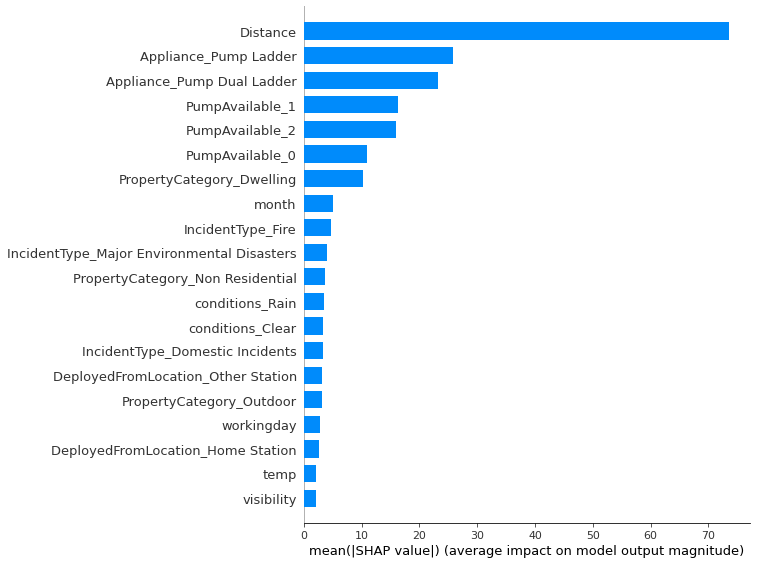

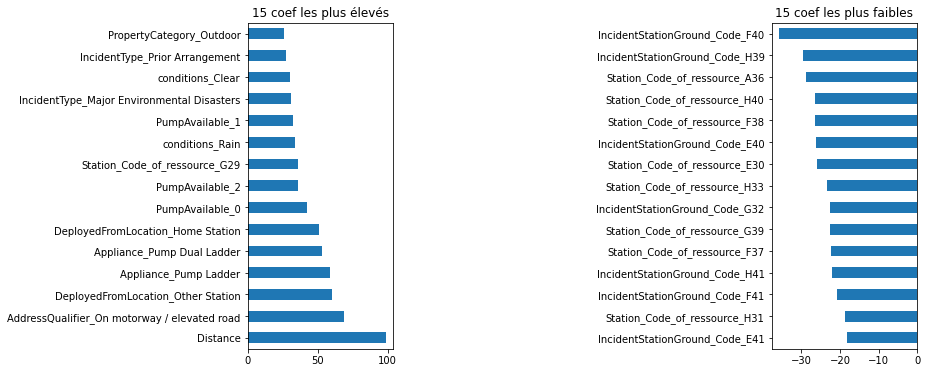

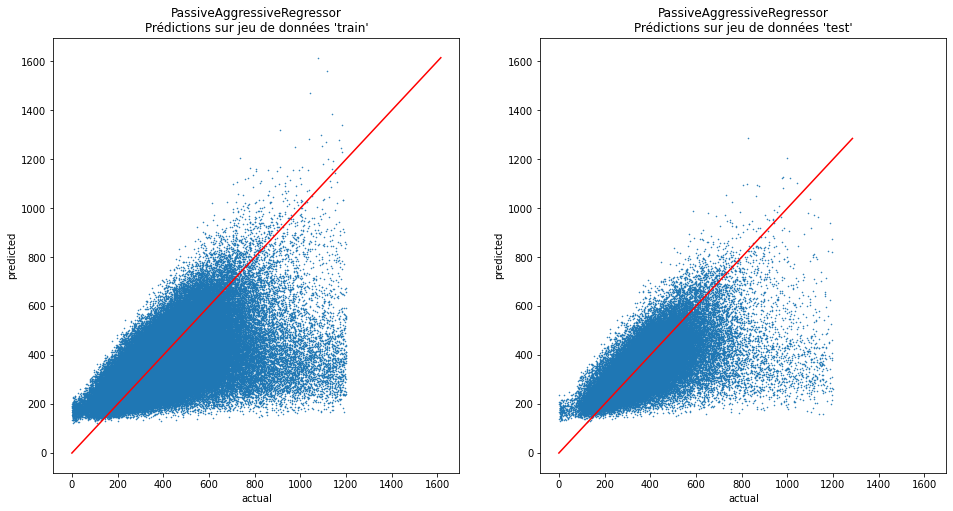

In [ ]:
# Nom de fichier du modèle sauvegardé
model_name = 'PassiveAggressiveRegressor'  # nom de la sauvegarde (sans extension)
joblib_file = model_name + '.joblib'       # fichier joblib de ce modèle

# Générer les prédictions, et les scores
model_name, par, pred_train_par, pred_test_par, metrics_par = model_calc(model_name, joblib_file,
                                                                         X_train, y_train,
                                                                         X_test, y_test)

# Visu valeur de Shapley + coefficients
plt_reg_var_importance(par, X_train, X_test)

# Visu des réel vs prédictions
plot_reg_predict(y_train, pred_train_par, y_test, pred_test_par)


# DIAGNOSTIC DU MODELE (résumé de l'analyse)

## Diagnostic des prédictions
Comportements des modèles sur jeu de données test (données nouvelles) : réels vs prédictions

In [ ]:
#Stocker les prédictions et calculer les écarts absolus

# création un df pour analyser les prédictions sur test
test_target_vs_pred = y_test.to_frame()

# Ajouter les prédictions du modèle
test_target_vs_pred['pred_par'] = np.round(vars()['pred_test_par'], 0)  

# Calculer l'écart absolu
test_target_vs_pred['abs_err_par'] = np.abs(test_target_vs_pred['AttendanceTimeSeconds'] - test_target_vs_pred['pred_par'])

test_target_vs_pred.head()

,AttendanceTimeSeconds,pred_par,abs_err_par
6,269,317.0,48.0
7,260,322.0,62.0
9,270,218.0,52.0
18,271,310.0,39.0
19,268,312.0,44.0


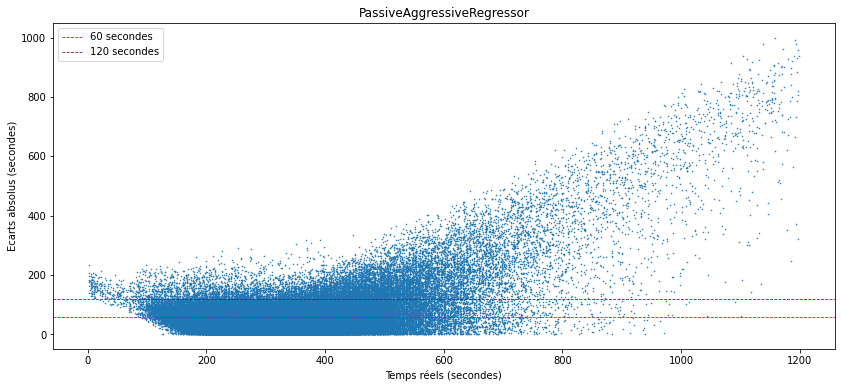

In [ ]:
# Visu des niveaux d'erreurs (val absolue) en fonction du temps réel

# Liste des colonnes des écarts absolus des modèles
# model_err = ['abs_err_' + alias for alias in models_short]

# nb_rows = len(models_list)
plt.figure(figsize=(14,6))
plt.scatter(test_target_vs_pred['AttendanceTimeSeconds'], test_target_vs_pred['abs_err_par'], s = 0.3)
plt.axhline(60, c='red', ls='--', lw=0.8, label = '60 secondes')
plt.axhline(120, c='purple', ls='--', lw=0.8, label = '120 secondes')
plt.xlabel('Temps réels (secondes)')
plt.ylabel('Ecarts absolus (secondes)')
plt.title(model_name)
plt.legend();

# Idéalement, tous les points devraient tracer une ligne horizontale y=0
# difficultés sur temps très courts, et temps élevés

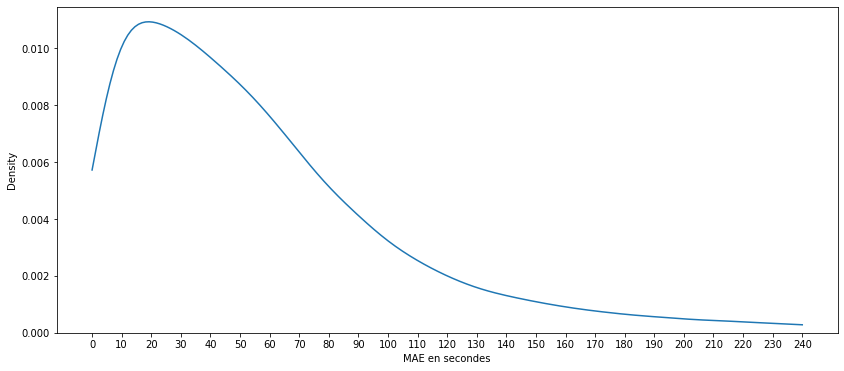

In [ ]:
# densité estimée des écarts en valeurs absolues
plt.figure(figsize=(14,6))
sns.kdeplot(data = test_target_vs_pred['abs_err_par'], clip=(0,240), legend=True)
plt.xticks(range(0,250,10))
plt.xlabel('MAE en secondes');

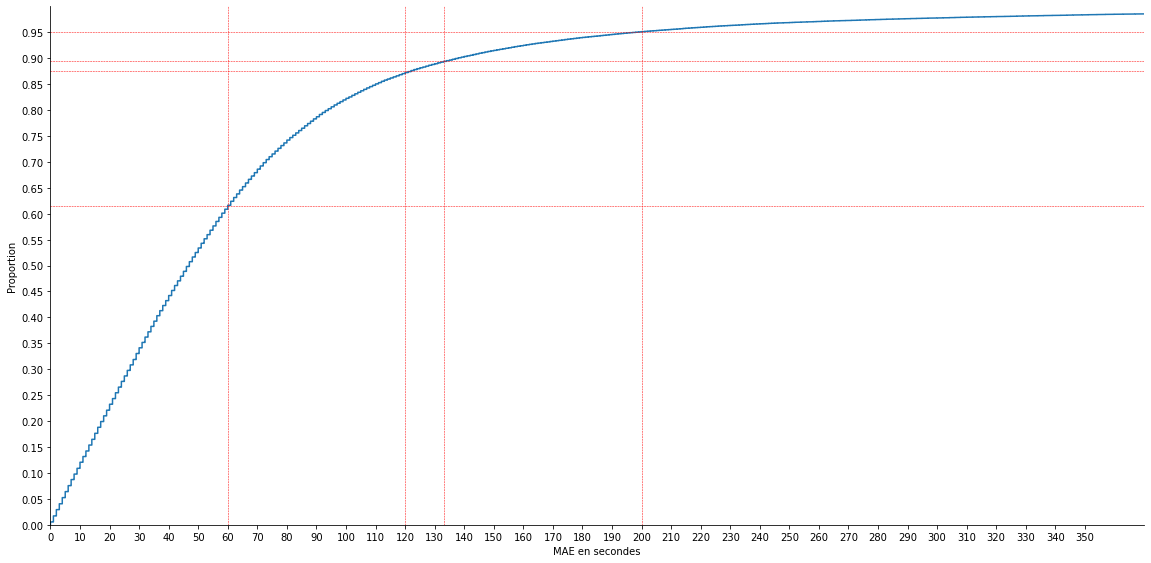

In [ ]:
# fonction de répartition empirique des écarts absolus
sns.displot(data = test_target_vs_pred['abs_err_par'], kind = 'ecdf',height=8, aspect=2)
plt.xticks(range(0,360,10))
plt.yticks(np.arange(0,1,0.05))
plt.xlim([0,370])
plt.xlabel('MAE en secondes')

# Mise en évidence de valeurs importantes
plt.axhline(y=0.95, ls="--", c='red',lw=0.5)  # 95.0% des prédictions ont moins de 200 secondes d'écart
plt.axhline(y=0.895, ls="--", c='red',lw=0.5) # 89.5% des prédictions avec environ 133 secondes d'écart
plt.axhline(y=0.875, ls="--", c='red',lw=0.5) # 87.5% des prédictions avec environ 120 secondes d'écart
plt.axhline(y=0.615, ls="--", c='red',lw=0.5) # 61.5% des prédictions avec maxi 60 secondes écarts

plt.axvline(x=200, ls="--", c='red', lw=0.5)
plt.axvline(x=133, ls="--", c='red', lw=0.5)
plt.axvline(x=120, ls="--", c='red', lw=0.5)
plt.axvline(x=60, ls="--", c='red', lw=0.5);


## Diagnostic vs classification

### Préparer les bases de travail

In [ ]:
# Données (variable cible) du jeu de test (régression)
y_test

6         269
7         260
9         270
18        271
19        268
         ... 
547840    416
547846    333
547859    308
547860    286
547861    330
Name: AttendanceTimeSeconds, Length: 109499, dtype: int64

In [ ]:
# Lecture du fichier des prédictions de classification
pred_test_over_360 = pd.read_pickle('/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_target_360/y_pred.pkl')
pred_test_over_360

# visu pour s'assurer que les index et la longueur correspondent aux enregistrements de y_test
# pour être sûr de travailler sur les mêmes observations

6         0
7         0
9         0
18        0
19        0
         ..
547840    1
547846    0
547859    1
547860    1
547861    1
Length: 109499, dtype: int64

In [ ]:
# concaténer (juxtaposer) les données des prédictions avec les infos d'origine du jeu de test (non dicho / normalisé)
# en veillant à supprimer 'AttendanceTimeSeconds' de df pour ne pas avoir 2 fois ces données !
concat_test_pred = pd.concat([df.drop('AttendanceTimeSeconds', axis=1).loc[list(test_target_vs_pred.index)], test_target_vs_pred], axis=1)

# Concaténer les classifications avec les analyses de régression
concat_test_pred_classif = concat_test_pred.join(pd.DataFrame(pred_test_over_360, columns=['pred_classif']))

# Contrôle si aucun NaN dans les classif (si index étaient bien strictement identiques)
display(concat_test_pred_classif[concat_test_pred_classif['pred_classif'].isna()])
# Ok, pas de valeurs manquantes

# Aperçu du df résultat
concat_test_pred_classif.head()

,DeployedFromLocation,Appliance,PropertyCategory,AddressQualifier,IncidentType,Distance,TotalOfPumpInLondon_Out,Station_Code_of_ressource,IncidentStationGround_Code,PumpAvailable,month,temp,precip,cloudcover,visibility,conditions,workingday,school_holidays,congestion_rate,AttendanceTimeSeconds,pred_par,abs_err_par,pred_classif


,DeployedFromLocation,Appliance,PropertyCategory,AddressQualifier,IncidentType,Distance,TotalOfPumpInLondon_Out,Station_Code_of_ressource,IncidentStationGround_Code,PumpAvailable,month,temp,precip,cloudcover,visibility,conditions,workingday,school_holidays,congestion_rate,AttendanceTimeSeconds,pred_par,abs_err_par,pred_classif
6,Home Station,Pump Dual Ladder,Non Residential,Correct incident location,Fire,1.865,6,A41,A43,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,269,317.0,48.0,0
7,Home Station,Pump Ladder,Non Residential,Correct incident location,Fire,1.865,7,A41,A43,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,260,322.0,62.0,0
9,Home Station,Pump Dual Ladder,Dwelling,Correct incident location,Fire,0.582,9,H22,H22,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,270,218.0,52.0,0
18,Home Station,Pump Dual Ladder,Outdoor Structure,On land associated with building,Fire,1.629,3,H22,H22,2,1,7.6,0.0,0.3,31.5,Clear,0,1,0.30,271,310.0,39.0,0
19,Home Station,Pump Ladder,Outdoor Structure,On land associated with building,Fire,1.629,4,H22,H22,1,1,7.6,0.0,0.3,31.5,Clear,0,1,0.30,268,312.0,44.0,0


In [ ]:
# transformation des données en classification : temps réels et temps prédits par les algorithmes de régression
# règle = 0 (temps <=360) ou 1 (temps > 360)

# Liste des colonnes des temps à classifier
col_seconds = ['AttendanceTimeSeconds', 'pred_par']

# Initialisation d'une liste des nouvelles colonnes (classif temps) créées
col_seconds_class = []

for col in col_seconds:
    newcol= "class_" + col
    col_seconds_class.append(newcol)
    concat_test_pred_classif[newcol] = np.where(concat_test_pred_classif[col] > 360, 1, 0).tolist()

concat_test_pred_classif.head()

,DeployedFromLocation,Appliance,PropertyCategory,AddressQualifier,IncidentType,Distance,TotalOfPumpInLondon_Out,Station_Code_of_ressource,IncidentStationGround_Code,PumpAvailable,month,temp,precip,cloudcover,visibility,conditions,workingday,school_holidays,congestion_rate,AttendanceTimeSeconds,pred_par,abs_err_par,pred_classif,class_AttendanceTimeSeconds,class_pred_par
6,Home Station,Pump Dual Ladder,Non Residential,Correct incident location,Fire,1.865,6,A41,A43,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,269,317.0,48.0,0,0,0
7,Home Station,Pump Ladder,Non Residential,Correct incident location,Fire,1.865,7,A41,A43,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,260,322.0,62.0,0,0,0
9,Home Station,Pump Dual Ladder,Dwelling,Correct incident location,Fire,0.582,9,H22,H22,2,1,7.0,0.3,0.2,29.0,Rain,0,1,0.47,270,218.0,52.0,0,0,0
18,Home Station,Pump Dual Ladder,Outdoor Structure,On land associated with building,Fire,1.629,3,H22,H22,2,1,7.6,0.0,0.3,31.5,Clear,0,1,0.30,271,310.0,39.0,0,0,0
19,Home Station,Pump Ladder,Outdoor Structure,On land associated with building,Fire,1.629,4,H22,H22,1,1,7.6,0.0,0.3,31.5,Clear,0,1,0.30,268,312.0,44.0,0,0,0


### Comparaison globale
predictions classification = predictions regression = données réelles

In [ ]:
# Afficher des tableaux de synthèse : classe réelle vs classification vs régression

denom = concat_test_pred_classif.shape[0] # dénominateur pour calculer les % = nb observations
col = 'class_pred_par'                    # modèle analysé

# création d'un df de synthèse
class_glob_compar_df = pd.DataFrame(concat_test_pred_classif.groupby(by=['class_AttendanceTimeSeconds', 'pred_classif', col])['IncidentType'].count())
# décompte des classifications identiques entre réel / classif / prédiction temps
nb_class_same = class_glob_compar_df.loc[0,0,0].sum() + class_glob_compar_df.loc[1,1,1].sum()
display(class_glob_compar_df)
print('\n', nb_class_same, 'observations aux classes identiques, soit %0.2f' %(100*nb_class_same/denom), '%\n')


IncidentType
class_AttendanceTimeSeconds pred_classif class_pred_par              
0                           0            0                      51345
                            1            0                       7484
                                         1                       8241
1                           0            0                       8690
                            1            0                       5149
                                         1                      28590


 79935 observations aux classes identiques, soit 73.00 %



### Régression vs réel
predictions regression = données réelles

In [ ]:
# Afficher des tableaux de synthèse : classe réelle vs régression

denom = concat_test_pred_classif.shape[0] # dénominateur pour calculer les % = nb observations
col = 'class_pred_par'                    # modèle analysé    

# Afficher les crosstab
display(pd.crosstab(concat_test_pred_classif['class_AttendanceTimeSeconds'],
                    concat_test_pred_classif[col],
                    rownames = ['Classe réelle'],
                    colnames = [col]))
print('\n')

# Analyse plus détaillée
# création d'un df de synthèse
class_reg_compar_df = pd.DataFrame(concat_test_pred_classif.groupby(by=['class_AttendanceTimeSeconds', col])['IncidentType'].count())
# décompte des class identiques entre réel + prédiction temps
nb_class_same = class_reg_compar_df.loc[0,0].sum() + class_reg_compar_df.loc[1,1].sum()
display(class_reg_compar_df)
print('\n', nb_class_same, 'observations aux classes identiques, soit %0.2f' %(100*nb_class_same/denom), '%')


class_pred_par,0,1
Classe réelle,,
0,58829,8241
1,13839,28590


IncidentType
class_AttendanceTimeSeconds class_pred_par              
0                           0                      58829
                            1                       8241
1                           0                      13839
                            1                      28590


 87419 observations aux classes identiques, soit 79.84 %


### Régression vs classif
predictions classification = predictions regression

In [ ]:
# Afficher des tableaux de synthèse : prédictions classification vs régression

denom = concat_test_pred_classif.shape[0] # dénominateur pour calculer les % = nb observations
col = 'class_pred_par'                    # modèle analysé

# Afficher les crosstab
display(pd.crosstab(concat_test_pred_classif['pred_classif'],
                    concat_test_pred_classif[col],
                    rownames = ['Prédictions classif'],
                    colnames = [col]))
print('\n')

# Analyse plus détaillée
# création d'un df de synthèse
class_clf_compar_df = pd.DataFrame(concat_test_pred_classif.groupby(by=['pred_classif', col])['IncidentType'].count())
# décompte des class identiques entre réel + prédiction temps
nb_class_same = class_clf_compar_df.loc[0,0].sum() + class_clf_compar_df.loc[1,1].sum()
display(class_clf_compar_df)
print('\n', nb_class_same, 'observations aux classes identiques, soit %0.2f' %(100*nb_class_same/denom), '%')


class_pred_par,0,1
Prédictions classif,,
0,60035,0
1,12633,36831


IncidentType
pred_classif class_pred_par              
0            0                      60035
1            0                      12633
             1                      36831


 96866 observations aux classes identiques, soit 88.46 %


Intéressant :
*   un véhicule pour lequel la classification ne prédit pas de retard (classe 0), aura un temps prédit <= 360 secondes par la régression ;
*   un véhicules pour lequel la régression prédit un temps > 360 secondes, sera de classe 1 dans les travaux de classification.

#### Classification_report

In [ ]:
# Afficher matrice de confusion et classification report liés aux travaux de régression
# si on utilisait ce modèle, en convertissant les résultats obtenus en une classification 0/1
# Rappel : classe 0 pour les temps<=360 secondes ; classe 1 pour les temps>360 secondes

print(pd.crosstab(concat_test_pred_classif['class_AttendanceTimeSeconds'], concat_test_pred_classif['class_pred_par']), '\n')
print(classification_report(concat_test_pred_classif['class_AttendanceTimeSeconds'], concat_test_pred_classif['class_pred_par']))

class_pred_par                   0      1
class_AttendanceTimeSeconds              
0                            58829   8241
1                            13839  28590 

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     67070
           1       0.78      0.67      0.72     42429

    accuracy                           0.80    109499
   macro avg       0.79      0.78      0.78    109499
weighted avg       0.80      0.80      0.80    109499



A comparer au **Classification Report du meilleur modèle de classification** (ci-dessous) :

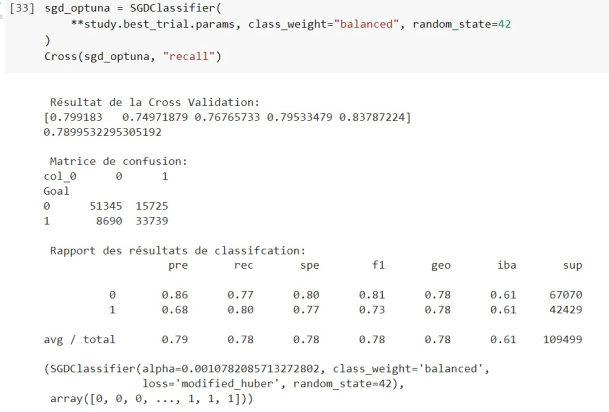


### Conclusion

Ce modèle de régression dont nous exploitons (transformons) les résultats  sous forme de classe, n'atteint pas un recall sur la classe 1, du niveau obtenu en classification.

Régression et classification présentent entre eux, un taux de prédictions identiques de 88.46 %, avec les points remarquables suivants :
*   un véhicule pour lequel la classification ne prédit pas de retard (classe 0), aura un temps prédit <= 360 secondes par la régression ;
*   un véhicules pour lequel la régression prédit un temps > 360 secondes, sera de classe 1 dans les travaux de classification.

Par contre, cela ne représente que 73 % des classes réelles qui sont correctement appréhendés par les 2 modèles considérés ensemble.

# APPLICATION à quelques incidents

In [ ]:
# Récupérer les paramètres : liste des stations, liste des incidents issus de jeu test, et afficher les incidents.

# Récupérer la liste des stations présentant des temps plus élevés
topslowest_code = list(pd.read_csv("/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_attendance_time/topslowest_code.csv")['0'])

# Créer un dataframe des incidents pour démo potentielles
demo_df = pd.DataFrame()
demo_df[['inc_number', 'inc_type']] = ''

# Ajouter les incidents + donner un résumé du scénario
demo_df = demo_df.append({'inc_number' : '147682-31102021', 'inc_type' : '3 véhicules (pas de risques)'}, ignore_index= True)
demo_df = demo_df.append({'inc_number' : '007657-19012018', 'inc_type' : '2 véhicules (du top)'}, ignore_index= True)
demo_df = demo_df.append({'inc_number' : '086491-01072018', 'inc_type' : '5 véhicules (dont 2 du top)'}, ignore_index= True)
demo_df = demo_df.append({'inc_number' : '041718-12042021', 'inc_type' : '2 véhicules (dont 1 du top) + motorway'}, ignore_index= True)

# créer colonne contenant les index des véhicules dans le jeu de test
demo_df['pump_index'] = demo_df['inc_number'].apply(lambda x: list(df_full[df_full['IncidentNumber'] == x].index))

# créer colonne contenant le nombre de véhicules dans le jeu de test
demo_df['pump_count'] = demo_df['inc_number'].apply(lambda x: len(df_full[df_full['IncidentNumber'] == x]))

# visu de la table des incidents pour démo
print("Sélection d'incidents pour application :")
display(demo_df)
           

# visualisation des véhicules par incident
print('-------------------------\n', '\nDétail des véhicules pour les incidents sélectionnés :\n')
for i in demo_df.index:
    # afficher le n° de l'incident et sa description rapide
    print(demo_df['inc_number'][i], ':', demo_df['inc_type'][i], '\n')
    # afficher les véhicules de l'incident
    display(df_full.loc[demo_df['pump_index'][i]])
    print('-------------------------\n')


Sélection d'incidents pour application :


,inc_number,inc_type,pump_index,pump_count
0,147682-31102021,3 véhicules (pas de risques),"[547859, 547860, 547861]",3
1,007657-19012018,2 véhicules (du top),"[5855, 5856]",2
2,086491-01072018,5 véhicules (dont 2 du top),"[68903, 68904, 68905, 68906, 68907]",5
3,041718-12042021,2 véhicules (dont 1 du top) + motorway,"[462819, 462820]",2


-------------------------
 
Détail des véhicules pour les incidents sélectionnés :

147682-31102021 : 3 véhicules (pas de risques) 



,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
547859,147682-31102021,F321,2021-10-31,66,242,308,F32,Stoke Newington,Home Station,2,No delay,Pump Dual Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Homerton,2,3,1,Fire,AFA,1,1.766,5,2,F32,F28,0,2,2021,10,31,Sunday,23,10.5,0.0,0.1,28.6,Clear,clear-night,0,0.0,0.1
547860,147682-31102021,F322,2021-10-31,79,207,286,F32,Stoke Newington,Home Station,1,No delay,Pump Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Homerton,2,3,1,Fire,AFA,1,1.766,6,2,F32,F28,0,2,2021,10,31,Sunday,23,10.5,0.0,0.1,28.6,Clear,clear-night,0,0.0,0.1
547861,147682-31102021,A301,2021-10-31,91,239,330,A30,Islington,Home Station,3,No delay,Pump Dual Ladder,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Correct incident location,Homerton,2,3,1,Fire,AFA,1,2.186,7,2,A30,F28,0,2,2021,10,31,Sunday,23,10.5,0.0,0.1,28.6,Clear,clear-night,0,0.0,0.1


-------------------------

007657-19012018 : 2 véhicules (du top) 



,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
5855,007657-19012018,G302,2018-01-19,148,138,286,G30,Wembley,Home Station,1,No delay,Pump Ladder,Other Residential,Hostel (e.g. for homeless people),Correct incident location,Wembley,1,2,1,Fire,False alarm - Malicious,1,0.606,3,2,G30,G30,0,2,2018,1,19,Friday,2,2.6,0.0,0.0,28.3,Clear,clear-night,1,0.0,0.04
5856,007657-19012018,G301,2018-01-19,125,180,305,G30,Wembley,Home Station,2,No delay,Pump Dual Ladder,Other Residential,Hostel (e.g. for homeless people),Correct incident location,Wembley,1,2,1,Fire,False alarm - Malicious,1,0.606,4,2,G30,G30,1,1,2018,1,19,Friday,2,2.6,0.0,0.0,28.3,Clear,clear-night,1,0.0,0.04


-------------------------

086491-01072018 : 5 véhicules (dont 2 du top) 



,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
68903,086491-01072018,E271,2018-07-01,81,431,512,E27,Erith,Home Station,5,No delay,Pump Dual Ladder,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Within same building,Plumstead,3,5,1,Fire,False alarm - Good intent,1,5.814,18,2,E27,E25,0,2,2018,7,1,Sunday,21,25.1,0.0,0.5,32.2,Clear,clear-day,0,0.0,0.16
68904,086491-01072018,E231,2018-07-01,73,385,458,E23,East Greenwich,Home Station,3,No delay,Pump Dual Ladder,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Within same building,Plumstead,3,5,1,Fire,False alarm - Good intent,1,3.658,19,2,E23,E25,0,2,2018,7,1,Sunday,21,25.1,0.0,0.5,32.2,Clear,clear-day,0,0.0,0.16
68905,086491-01072018,E251,2018-07-01,100,140,240,E25,Plumstead,Home Station,1,No delay,Pump Dual Ladder,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Within same building,Plumstead,3,5,1,Fire,False alarm - Good intent,1,1.421,20,2,E25,E25,0,2,2018,7,1,Sunday,21,25.1,0.0,0.5,32.2,Clear,clear-day,0,0.0,0.16
68906,086491-01072018,E252,2018-07-01,65,189,254,E25,Plumstead,Home Station,2,No delay,Pump Ladder,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Within same building,Plumstead,3,5,1,Fire,False alarm - Good intent,1,1.421,21,2,E25,E25,1,1,2018,7,1,Sunday,21,25.1,0.0,0.5,32.2,Clear,clear-day,0,0.0,0.16
68907,086491-01072018,E232,2018-07-01,81,388,469,E23,East Greenwich,Home Station,4,No delay,Pump Ladder,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Within same building,Plumstead,3,5,1,Fire,False alarm - Good intent,1,3.658,22,2,E23,E25,2,0,2018,7,1,Sunday,21,25.1,0.0,0.5,32.2,Clear,clear-day,0,0.0,0.16


-------------------------

041718-12042021 : 2 véhicules (dont 1 du top) + motorway 



,IncidentNumber,Resource_Code,DateAndTimeMobilised,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Appliance,PropertyCategory,PropertyType,AddressQualifier,IncidentStationGround,NumStationsWithPumpsAttending,NumPumpsAttending,Mobilised_Rank,IncidentType,IncidentCategory,FalseAlarm,Distance,TotalOfPumpInLondon_Out,PumpByStation,Station_Code_of_ressource,IncidentStationGround_Code,PumpOfIncidentStation_Out,PumpAvailable,year,month,day,weekday,hour,temp,precip,cloudcover,visibility,conditions,icon,workingday,school_holidays,congestion_rate
462819,041718-12042021,G302,2021-04-12,61,587,648,G30,Wembley,Home Station,2,Not held up,Pump Ladder,Outdoor,Golf course (not building on course),On motorway / elevated road,Northolt,2,2,1,Fire,False alarm - Good intent,1,2.698,3,2,G30,G31,0,2,2021,4,12,Monday,20,8.1,0.0,0.3,45.4,Clear,clear-night,1,0.0,0.17
462820,041718-12042021,G251,2021-04-12,50,300,350,G25,Ealing,Home Station,1,No delay,Pump Dual Ladder,Outdoor,Golf course (not building on course),On motorway / elevated road,Northolt,2,2,1,Fire,False alarm - Good intent,1,2.643,4,2,G25,G31,0,2,2021,4,12,Monday,20,8.1,0.0,0.3,45.4,Clear,clear-night,1,0.0,0.17


-------------------------



In [ ]:
# Application du modèle à ces incidents de démo

for i in demo_df.index:         # pour chaque incident identifié dans la talbe de démo
    
    # afficher le n° de l'incident et sa description rapide
    print(demo_df['inc_number'][i], ':', demo_df['inc_type'][i], "- Prédictions du modèle vs données réelles :\n")

    # créer la base pour les prédictions
    df_demo_full = df_full.loc[demo_df['pump_index'][i]]  # tous les véhicules de l'incident base de démo

    # calculer le nombre de véhicules à prédire (sera à ajuster selon prédiction nb véhicules)
    n_pump_predict = demo_df['pump_count'][i]

    # réduire la taille pour s'ajuster au nombre de véhicules à prédire (prendre les n_pump_predic premiers véhicules)
    df_demo = df_demo_full.iloc[:n_pump_predict,]
    # ---------
    # voir plus tard comment gérer si n_pump_predict > nombre des véhicules de l'incident en test
    # pour l'application streamlit
    # ---------

    # variables explicatives et cible de la démo
    X_test_demo = X_test[X_test.index.isin(df_demo.index)]
    y_test_demo = pd.DataFrame(y_test[y_test.index.isin(df_demo.index)])

    # calculer la prédiction (arrondir à la seconde)
    pred_demo = pd.DataFrame(par.predict(X_test_demo).round(), columns = ['Prediction'], index= X_test_demo.index)

    # prévoir une colonne pour signaler les risques de sous-estimation légère
    pred_demo['Risque sous-estimation légère'] = ''
    
    # identifier le numéro (index) de la colonne d'alerte pour sous-estimation possible
    under_estim_col = pred_demo.columns.get_loc('Risque sous-estimation légère')

    # analyse des cas de sous-estimation possible selon critères définis
    for i in pred_demo.index:                      # pour chaque index du dataframe
        row_num = list(pred_demo.index).index(i)   # calculer le numéro (index) de la ligne
        # voir si le code ressource du véhicule est une caserne du top
        if df_demo['Station_Code_of_ressource'][i] in topslowest_code:
            pred_demo.iloc[row_num, under_estim_col] = 'oui'   # si c'est une caserne du top, signaler risque par "oui"

    # compléter les prédictions par qq infos réelles (pour appréciation des résultats)
    pred_demo['Temps réel'] = y_test_demo
    pred_demo['Station Code of ressource'] = df_demo['Station_Code_of_ressource']
    pred_demo['Address Qualifier'] = df_demo['AddressQualifier']
    pred_demo['Deployed From Location'] = df_demo['DeployedFromLocation']
    pred_demo['Incident Station Ground Code'] = df_demo['IncidentStationGround_Code']

    display(pred_demo)
    print('-------------------------\n')

147682-31102021 : 3 véhicules (pas de risques) - Prédictions du modèle vs données réelles :



,Prediction,Risque sous-estimation légère,Temps réel,Station Code of ressource,Address Qualifier,Deployed From Location,Incident Station Ground Code
547859,356.0,,308,F32,Correct incident location,Home Station,F28
547860,362.0,,286,F32,Correct incident location,Home Station,F28
547861,382.0,,330,A30,Correct incident location,Home Station,F28


-------------------------

007657-19012018 : 2 véhicules (du top) - Prédictions du modèle vs données réelles :



,Prediction,Risque sous-estimation légère,Temps réel,Station Code of ressource,Address Qualifier,Deployed From Location,Incident Station Ground Code
5855,252.0,oui,286,G30,Correct incident location,Home Station,G30
5856,243.0,oui,305,G30,Correct incident location,Home Station,G30


-------------------------

086491-01072018 : 5 véhicules (dont 2 du top) - Prédictions du modèle vs données réelles :



,Prediction,Risque sous-estimation légère,Temps réel,Station Code of ressource,Address Qualifier,Deployed From Location,Incident Station Ground Code
68903,644.0,,512,E27,Within same building,Home Station,E25
68904,470.0,oui,458,E23,Within same building,Home Station,E25
68905,284.0,,240,E25,Within same building,Home Station,E25
68906,286.0,,254,E25,Within same building,Home Station,E25
68907,481.0,oui,469,E23,Within same building,Home Station,E25


-------------------------

041718-12042021 : 2 véhicules (dont 1 du top) + motorway - Prédictions du modèle vs données réelles :



,Prediction,Risque sous-estimation légère,Temps réel,Station Code of ressource,Address Qualifier,Deployed From Location,Incident Station Ground Code
462819,502.0,oui,648,G30,On motorway / elevated road,Home Station,G31
462820,465.0,,350,G25,On motorway / elevated road,Home Station,G31


-------------------------



Quelques commentaires sur ces résultats :

*   **147682-31102021** : prédictions acceptables pour ces 3 véhicules.

*   **007657-19012018** : prédictions acceptables pour tous les véhicules, la notion de potentielle sous-estimation légère est signalée à juste titre.

*   **086491-01072018** : sur les 2 véhicules du top, on signale un risque de sous-estimation alors que ce n'est pas le cas.

*   **041718-12042021** : prédictions globalement acceptables pour les 2 véhicules, le temps prédit pour le véhicule du top est effectivement sous-estimé.


# _

# $\color{red}{\text{Attention : ne pas exécuter le code en dessous de cette ligne}}$

(sauf nécessité de remettre à jour le modèle sauvegardé / refaire tourner le gridsearchcv -> au cas par cas !)

# _

# CONSTRUCTIONS ML
Pas nécessaire de relancer ce groupe de cellules (environ 8 minutes de traitement) :
*   Sur la totalité des variables : 
    *   travaux de recherche des paramètres (gridsearch)
    *   entrainement du modèle avec meilleurs paramètres trouvés
*   Sur la seule variable distance => idem


## Modèle sur totalité des variables

### GridSearchCV


In [ ]:
%%time
params = {'C' :[0.001, 0.0025, 0.005, 0.008, 0.01]}

grid = GridSearchCV(estimator = PassiveAggressiveRegressor(),
                    param_grid = params,
                    scoring = 'neg_mean_absolute_error',
                    verbose = 3,
                    cv = 3)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .........................C=0.001;, score=-70.167 total time=  58.5s
[CV 2/3] END .........................C=0.001;, score=-67.488 total time=  56.0s
[CV 3/3] END .........................C=0.001;, score=-66.101 total time=  45.1s
[CV 1/3] END ........................C=0.0025;, score=-70.171 total time=  39.9s
[CV 2/3] END ........................C=0.0025;, score=-67.418 total time=  41.3s
[CV 3/3] END ........................C=0.0025;, score=-66.126 total time=  23.7s
[CV 1/3] END .........................C=0.005;, score=-70.382 total time=  23.0s
[CV 2/3] END .........................C=0.005;, score=-67.471 total time=  19.5s
[CV 3/3] END .........................C=0.005;, score=-66.083 total time=  24.8s
[CV 1/3] END .........................C=0.008;, score=-70.116 total time=  21.9s
[CV 2/3] END .........................C=0.008;, score=-67.400 total time=  15.4s
[CV 3/3] END .........................C=0.008;, s

In [ ]:
%%time
print("Best params :", grid.best_params_)
print("MAE Train    :", -grid.score(X_train, y_train))
print("MAE Test     :", -grid.score(X_test, y_test))

Best params : {'C': 0.008}
MAE Train    : 67.55703517735573
MAE Test     : 67.37792307115186
CPU times: user 428 ms, sys: 76.1 ms, total: 504 ms
Wall time: 352 ms



```
params = {'C' :[0.001, 0.0025, 0.005, 0.008, 0.01]}

Best params : {'C': 0.008}
MAE Train    : 67.55703517735573
MAE Test     : 67.37792307115186
```

### Entrainement


In [ ]:
Ccv = grid.best_params_['C']

In [ ]:
%%time
par = PassiveAggressiveRegressor(C=Ccv)
par.fit(X_train, y_train)

CPU times: user 21.1 s, sys: 39.5 ms, total: 21.2 s
Wall time: 21.1 s


In [ ]:
# # Sauvegarder le modèle (s'il a été modifié => en dé-commentant le code)
# model_name = 'PassiveAggressiveRegressor'
# dump(par, reg_saved + model_name + '.joblib')

['/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_attendance_time/PassiveAggressiveRegressor.joblib']

## Modèle sur variable distance uniquement

### GridSearchCV


In [ ]:
%%time

# PAR distance only

params = {'C' :[0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.008, 0.01]}

grid = GridSearchCV(estimator = PassiveAggressiveRegressor(),
                    param_grid = params,
                    scoring = 'neg_mean_absolute_error',
                    verbose = 3,
                    cv = 3)
grid.fit(X_train_dist, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END ........................C=0.0001;, score=-72.159 total time=   1.9s
[CV 2/3] END ........................C=0.0001;, score=-69.538 total time=   2.6s
[CV 3/3] END ........................C=0.0001;, score=-67.832 total time=   1.5s
[CV 1/3] END ........................C=0.0005;, score=-72.151 total time=   0.5s
[CV 2/3] END ........................C=0.0005;, score=-69.539 total time=   0.5s
[CV 3/3] END ........................C=0.0005;, score=-67.835 total time=   0.6s
[CV 1/3] END .........................C=0.001;, score=-72.159 total time=   0.2s
[CV 2/3] END .........................C=0.001;, score=-69.545 total time=   0.2s
[CV 3/3] END .........................C=0.001;, score=-67.833 total time=   0.2s
[CV 1/3] END ........................C=0.0025;, score=-72.158 total time=   0.2s
[CV 2/3] END ........................C=0.0025;, score=-69.560 total time=   0.2s
[CV 3/3] END ........................C=0.0025;, s

In [ ]:
%%time
print("Best params :", grid.best_params_)
print("MAE Train    :", -grid.score(X_train_dist, y_train))
print("MAE Test     :", -grid.score(X_test_dist, y_test))

Best params : {'C': 0.005}
MAE Train    : 69.81680301259377
MAE Test     : 69.63659380046334
CPU times: user 15.1 ms, sys: 900 µs, total: 16 ms
Wall time: 17.6 ms




```
params = {'C' :[0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.008, 0.01]}

Best params : {'C': 0.005}
MAE Train    : 69.81680301259377
MAE Test     : 69.63659380046334

```



### Entrainement


In [ ]:
Ccv = grid.best_params_['C']
par = PassiveAggressiveRegressor(C=Ccv)
par.fit(X_train_dist, y_train)

In [ ]:
# # Sauvegarder le modèle (s'il a été modifié => en dé-commentant le code)
# model_name = 'PassiveAggressiveRegressor_distance_only'
# dump(par, reg_saved + model_name + '.joblib')

['/content/drive/MyDrive/Projet Pompier/Github/structure_finale/data_outputs/ml_attendance_time/PassiveAggressiveRegressor_distance_only.joblib']